In [170]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# nlp libraries 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

# logistic regression/classification metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Pipeline Hyperparameter Tuning 
from sklearn.pipeline import Pipeline, make_pipeline

import statistics as stats

In [171]:
# Import the posts data
posts = pd.read_csv('../../data/reddit_posts.csv', index_col=0).reset_index(drop=True)
posts.head()

,subreddit,title,created_utc,selftext,author,media_only,permalink
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...


#### Exploratory Data Analysis - Before tokenizing the text

<AxesSubplot:>

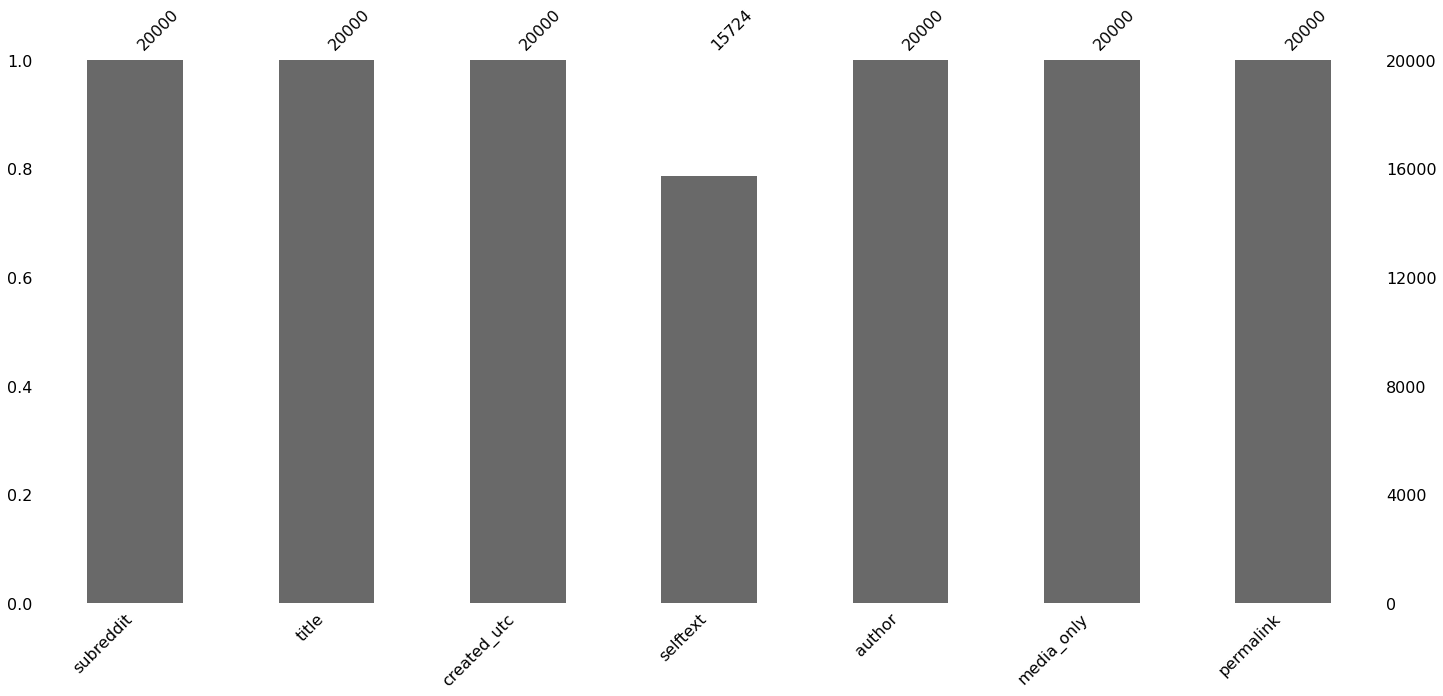

In [172]:
# Checks how many missing selftexts there are 
msno.bar(posts)

**Interpretation**: Although there are a lot of missing selftexts, I have decided to combine the title and the selftext columns and there seems to be no missing titles, which means, I may not have to drop as many observations as there are missing selftexts. 

In [173]:
# Creates a new dataframe with just the rows that have NAs for selftext
missing_posts_df = posts[posts['selftext'].isna()]

In [174]:
missing_posts_df

,subreddit,title,created_utc,selftext,author,media_only,permalink
27,tolkienfans,"In high school, I read The Lord of the Rings b...",1615997763,NaN,Present_Librarian668,False,/r/tolkienfans/comments/m740j3/in_high_school_...
29,tolkienfans,Tolkien and his wife Edith Bratt were related....,1615996066,NaN,mariegriffiths,False,/r/tolkienfans/comments/m73dil/tolkien_and_his...
55,tolkienfans,"Just found a 2nd edition, 13th impression of t...",1615896257,NaN,RaggedDawn,False,/r/tolkienfans/comments/m67ie4/just_found_a_2n...
69,tolkienfans,When did Saruman begin to desire power?,1615833140,NaN,rman20209,False,/r/tolkienfans/comments/m5rfqb/when_did_saruma...
75,tolkienfans,What character from Tolkien’s legendarium do y...,1615818387,NaN,Isaac_Ludwig666,False,/r/tolkienfans/comments/m5lu0d/what_character_...
...,...,...,...,...,...,...,...
19991,harrypotter,I finally have updated my mental reference for...,1610001727,NaN,lipozine,False,/r/harrypotter/comments/ks7n73/i_finally_have_...
19992,harrypotter,Antioch needs to go home and rethink his life,1610001594,NaN,LucarioNN,False,/r/harrypotter/comments/ks7m3f/antioch_needs_t...
19994,harrypotter,its possible,1610000614,NaN,Maansi_kochar,False,/r/harrypotter/comments/ks7e0o/its_possible/
19995,harrypotter,The pig do be looking like Harry potters uncle...,1610000358,NaN,livlido,False,/r/harrypotter/comments/ks7brs/the_pig_do_be_l...


In [175]:
# Checks how many of the missing are for each class
missing_posts_df['subreddit'].value_counts()

harrypotter    3434
tolkienfans     842
Name: subreddit, dtype: int64

In [176]:
# Counts the moderator's [deleted] or [removed] texts
text = posts['selftext'].value_counts(sort=True)
text[text > 1]

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Cleaning

In [177]:
# Makes a copy of the original dataset as a backup
posts_og = posts.copy()

In [178]:
# Changes moderator's '[removed]' and '[deleted]' to NaN
posts['selftext'] = posts['selftext'].replace(['[removed]', '[deleted]'], np.nan)

In [179]:
# Combines the title and the selftext, and replaces NaNs with the title
posts.insert(4, 'title_selftext', posts['title'] + ' ' + posts['selftext'])
posts['title_selftext'].fillna(posts['title'], inplace=True)

In [180]:
# Keeps the words only function 
def keep_words_only(text):
    """Cleans text so that any special characters are removed and only words are kept"""
    
    regex_tokenizer = RegexpTokenizer("\w+[']*")
    words = regex_tokenizer.tokenize(text.lower())
    
    return (' ').join(words)

In [181]:
# Applies the keep the words only function to the text column
posts['title_selftext'] = posts['title_selftext'].map(keep_words_only)

In [182]:
# Creates a new column containing the length of the text
posts['text_length'] = posts['title_selftext'].map(len)
posts.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731


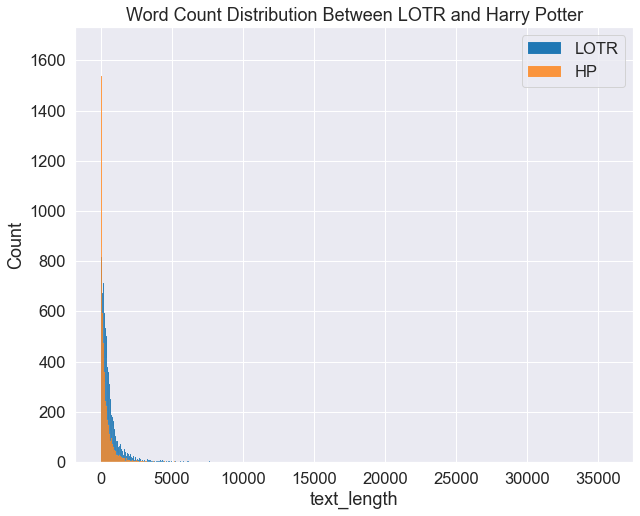

In [192]:
# Creates and saves the word count distribution between the two separate reddits
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
sns.histplot(posts[posts['subreddit'] == 'tolkienfans']['text_length'], label='LOTR', 
             color='tab:blue', alpha = 1);
sns.histplot(posts[posts['subreddit'] == 'harrypotter']['text_length'], label='HP', 
             color='tab:orange', alpha = 0.8)
plt.legend()
plt.title('Word Count Distribution Between LOTR and Harry Potter');
plt.savefig('../../presentation/imgs/word_count_hist.jpg')

**Interpretation**: The posts in the LOTR subreddit seemed to overall be a little bit longer in word count than the posts in the harry potter subreddit

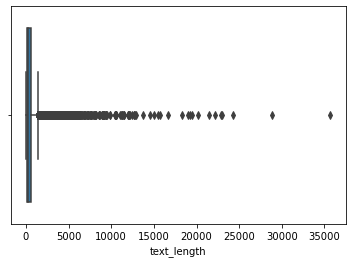

In [110]:
# Plots a boxplot of text_length
sns.boxplot(x=posts['text_length']);

**Interpretation**: Length/Word count of posts seemed to be skewed to the right. Which makes sense that more people would write less than more, if the reddit is more discussion based rather than opinion based

In [111]:
# prints summary statistics on text_length column
posts['text_length'].describe()

count    20000.000000
mean       538.937300
std       1088.059897
min          0.000000
25%         83.000000
50%        259.000000
75%        593.000000
max      35685.000000
Name: text_length, dtype: float64

In [112]:
# Checks the mode of the text length
stats.mode(posts['text_length'])

33

In [114]:
# Removes any observations that have a text length less than or equal to 10 words
posts = posts[posts['title_selftext'].map(len) > 10]

In [116]:
# Drops any remaining NAs up until this point in the preprocessing
posts.dropna(subset=['title_selftext'], inplace=True)

In [120]:
# Drops any duplicates in the text column
posts.drop_duplicates(subset=['title_selftext'], inplace=True)

In [122]:
def clean_text_stem(text):
    """Cleans text by keeping words only, tokenizing, stemming and removing stopwords"""
    #Instantiate tokenizer and stemmer and lemmatizer
    re_tokenizer = RegexpTokenizer("\w+")
    lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
        
    # Tokenze the text
    words = re_tokenizer.tokenize(text.lower())
    
    # Filter stop words
    stopwords_list = stopwords.words('english')
    
     # Adds custom stopwords to stopwords_list
#     custom = []
#     stopwords_list = stopwords_list + custom

    no_stops_stemmed = [p_stemmer.stem(word) for word in words if word.lower() not in stopwords_list]
    
    return (' ').join(no_stops_stemmed)

In [123]:
def clean_text_lem(text):
    """Cleans text by keeping words only, tokenizing, lemmatizing and removing stopwords"""
    #Instantiate tokenizer and stemmer and lemmatizer
    re_tokenizer = RegexpTokenizer("\w+")
    lemmatizer = WordNetLemmatizer()
    p_stemmer = PorterStemmer()
        
    # Tokenze the text
    words = re_tokenizer.tokenize(text.lower())
    
    # Filter stop words
    stopwords_list = stopwords.words('english')
    
     # Adds custom stopwords to stopwords_list
#     custom = []
#     stopwords_list = stopwords_list + custom

    no_stops_lemmatized = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stopwords_list]
    
    return (' ').join(no_stops_lemmatized)

In [124]:
# Creates two new clean_text columns, where one is stemmed and the other is lemmatized
posts['clean_text_stem'] = posts['title_selftext'].map(clean_text_stem)
posts['clean_text_lem'] = posts['title_selftext'].map(clean_text_lem)

In [125]:
# Shows the count of posts from each subreddit
posts['subreddit'].value_counts()

tolkienfans    9885
harrypotter    9429
Name: subreddit, dtype: int64

In [126]:
posts.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [81]:
# Resets the index after merging the two datasets 
posts.reset_index(drop=True, inplace=True)

In [82]:
posts.index

RangeIndex(start=0, stop=19314, step=1)

In [83]:
# Keeps the posts that had more than 10 words in both the stemmed and lemmatized columns
posts = posts[posts['clean_text_stem'].map(len) > 10]
posts = posts[posts['clean_text_lem'].map(len) > 10]

In [87]:
# Reset the index after removing some rows
posts.reset_index(drop=True, inplace=True)

In [91]:
# Saves the cleaned data to a csv file
posts.to_csv('../../data/clean_data/clean_posts.csv')

### Some EDA after CountVectorizing the Stemmed Text

In [128]:
df = posts

In [129]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()


# Set up X and y
X = df['clean_text_stem']
y = df['subreddit']

# Splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

# Fits and transforms the vectorizer on our corpus
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

X_train_df = pd.DataFrame(X_train.toarray(), columns=cvec.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(), columns=cvec.get_feature_names())

X_train_df = X_train_df.loc[:, 'aback':]
X_test_df = X_test_df.loc[:, 'aback':]

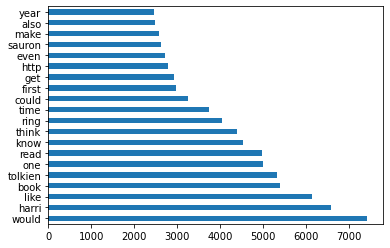

In [131]:
# plot top occurring words
common_stem_words = X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
common_stem_words
plt.savefig('../../presentation/imgs/common_stem_words.jpg')

**Interpretation**: The most common words were 'harri' and words like 'tolkien' which makes sense from each subreddit. 'book' is also a frequent word, though it was unclear which subreddit it originated from since, both subreddits were about books as well as the movies of these series. 

### Some EDA after CountVectorizing the Lemmatized Text

In [151]:
df = posts

In [153]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [154]:
# Set up X and y
X = df['clean_text_lem']
y = df['subreddit']

In [155]:
# Splits the data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

In [156]:
# Fits and transforms the vectorizer on our corpus
X_train = cvec.fit_transform(X_train1)
X_test = cvec.transform(X_test1)

In [157]:
X_train

<14485x33763 sparse matrix of type '<class 'numpy.int64'>'
	with 555398 stored elements in Compressed Sparse Row format>

In [158]:
# Created the X_train and X_test dataframes so that individual words could be shown
X_train_df = pd.DataFrame(X_train.toarray(), columns=cvec.get_feature_names())
X_test_df = pd.DataFrame(X_test.toarray(), columns=cvec.get_feature_names())

In [159]:
# Removed the x predictors that were only numbers
X_train_df = X_train_df.loc[:, 'aback':]
X_test_df = X_test_df.loc[:, 'aback':]

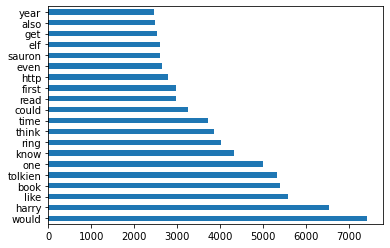

In [163]:
# plot top occurring words
common_lem_words = X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
common_lem_words;
plt.savefig('../../presentation/imgs/common_lem_words.jpg')

**Interpretation**: The most common lemmatized words were very similar to the most common stemmed words. 